## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

Matplotlib created a temporary cache directory at /mnt/e/Anisotropic-Resistivity-Inversion/matplotlib-2tloovsv because the default path (/home/misaelmorales/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [107]:
def plot_pinn_results(df, figsize=(15,10), subtitle:str=None):
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4 = axs

    ax11 = ax1.twiny()
    ari.plot_curve(ax1, df, 'GR', 0, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax11, df, 'Csh_pred', 0, 1, 'k', units='v/v')

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2, df, 'AT10', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax21, df, 'AT90', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax22, df, 'Rss_pred', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax31, df, 'Rv', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, df, 'Rv_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax3, df, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax41, df, 'Rh', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax42, df, 'Rh_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax4, df, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in axs]
    ax1.invert_yaxis()
    if subtitle is None:
        title = 'PINN Inversion Results'
    else:
        title = 'PINN Inversion Results | {}'.format(subtitle)
    fig.suptitle(title, weight='bold')
    plt.tight_layout()
    plt.show()

In [270]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.rn1 = nn.LSTM(input_size=64,  hidden_size=128, num_layers=2, batch_first=True, dropout=0.1)
        self.rn2 = nn.LSTM(input_size=128, hidden_size=64,  num_layers=2, batch_first=True, dropout=0.1)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x, _ = self.rn1(x)
        x = nn.ReLU()(x)
        x, _ = self.rn2(x)
        x = nn.ReLU()(self.fc3(x))
        return x

In [271]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self):
        super(PhysicsInformedLoss, self).__init__()

    def forward(self, inputs, outputs):
        Rv_true, Rh_true = inputs[:, 0],       inputs[:, 1]
        Rvsh,    Rhsh    = torch.max(Rv_true), torch.max(Rh_true)
        Csh,     Rss     = outputs[:, 0],      outputs[:, 1]
    
        Rvsim = (Csh*Rvsh + (1-Csh)*Rss)
        Rhsim = 1 / (Csh/Rhsh + (1-Csh)/Rss)

        Rverr = torch.abs((Rv_true - Rvsim)/Rv_true)
        Rherr = torch.abs((Rh_true - Rhsim)/Rh_true)
        costf = torch.cat((Rverr, Rherr), dim=0)
        Csh   = torch.clamp(Csh, 0, 1)
        loss  = torch.norm(costf, p=2) + 1e-8*torch.norm(inputs, p=2)
        return loss

In [272]:
d = lasio.read('well1.las').df()[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
#d = lasio.read('well2.LAS').df()[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()

column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
data = d.rename(columns=dict(zip(d.columns, column_names)))

res_aniso  = data[['Rv','Rh']]

Rvsh_win = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
Rhsh_win = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
Csh_lin  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())

R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

In [273]:
inputs         = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset        = TensorDataset(inputs)
xtrain, xvalid = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
trainloader    = DataLoader(xtrain, batch_size=250, shuffle=False)
validloader    = DataLoader(xvalid, batch_size=250, shuffle=False)

model      = PINNari()
criterion  = PhysicsInformedLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

epochs = 301
train_loss, valid_loss = [], []

for epoch in range(epochs):
    
    epoch_train_loss = []
    model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        y = model(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))

    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        y = model(x)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))

    if epoch % 50 == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

Epoch: 0 | Loss: 28.6107 | Valid Loss: 23.6311
Epoch: 50 | Loss: 5.8529 | Valid Loss: 5.0121
Epoch: 100 | Loss: 4.5217 | Valid Loss: 3.5390
Epoch: 150 | Loss: 3.7457 | Valid Loss: 2.2283
Epoch: 200 | Loss: 2.3063 | Valid Loss: 1.7716
Epoch: 250 | Loss: 2.1866 | Valid Loss: 1.5951
Epoch: 300 | Loss: 1.6622 | Valid Loss: 1.2153


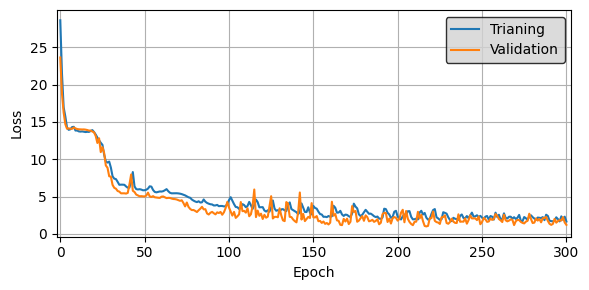

In [274]:
plt.figure(figsize=(6,3))
plt.plot(range(epochs), train_loss, label='Trianing', c='tab:blue')
plt.plot(range(epochs), valid_loss, label='Validation', c='tab:orange')
plt.legend(facecolor='lightgrey', edgecolor='k')
plt.grid(True, which='both')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.xlim(-2, epochs+2)
plt.tight_layout()
plt.show()

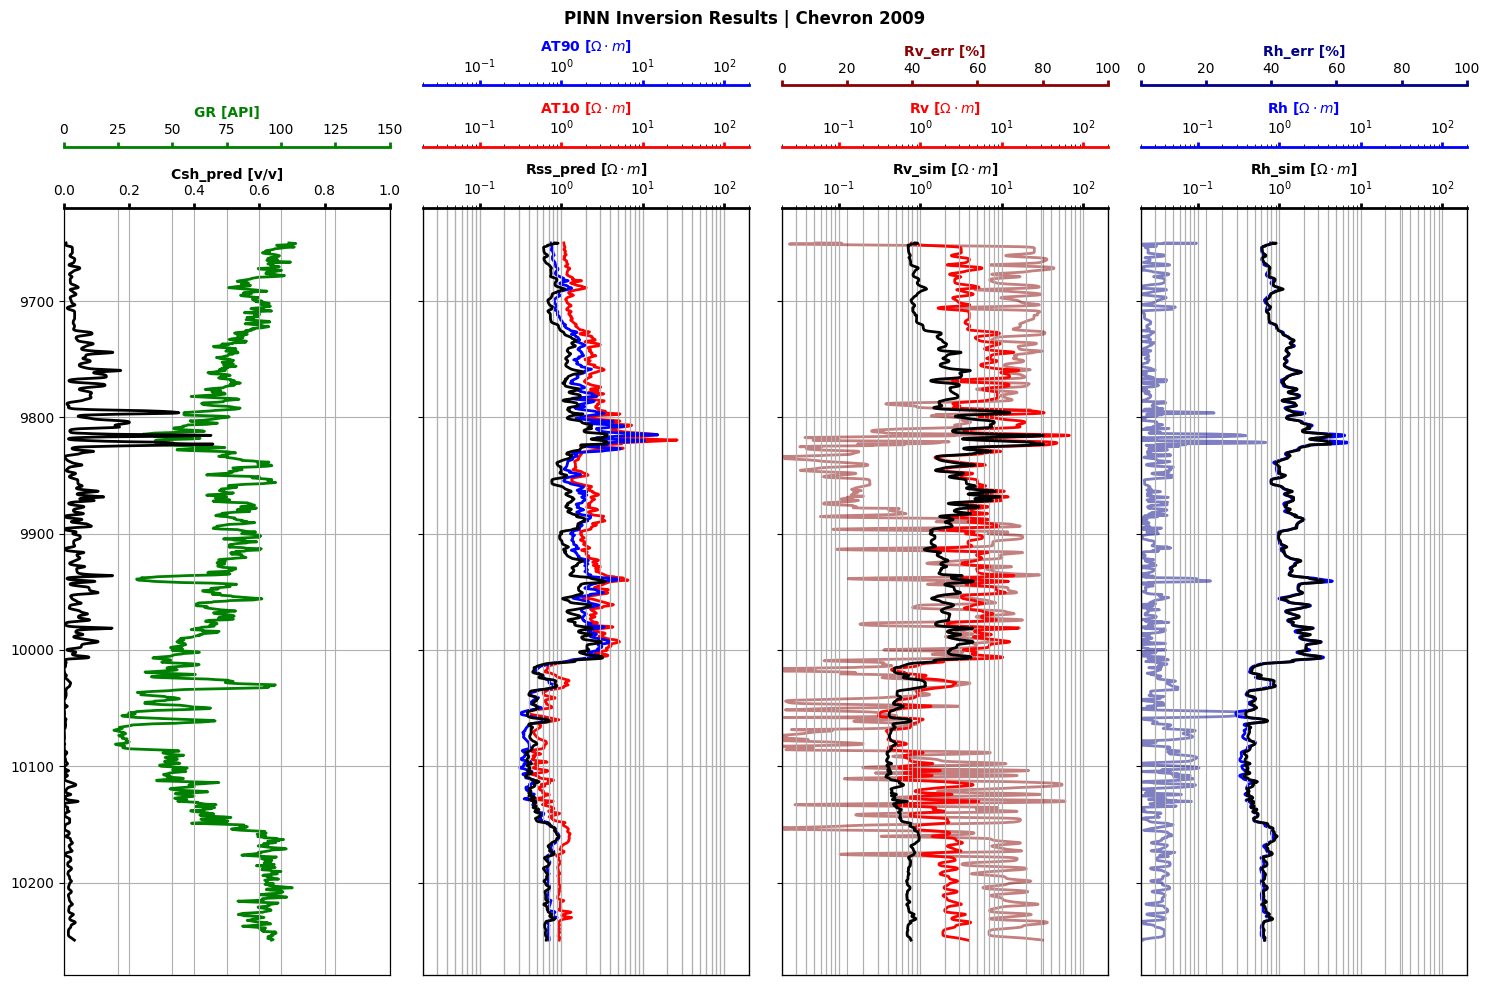

In [275]:
y = model(inputs).detach().numpy()
csh_pred, rss_pred = y[:,0], y[:,1]

Rv_sim = (csh_pred*Rvsh_win + (1-csh_pred)*rss_pred)
Rh_sim = 1 / (csh_pred/Rhsh_win + (1-csh_pred)/rss_pred)
Rv_err = np.abs((Rv_sim - data['Rv'].values)/data['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - data['Rh'].values)/data['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rss_pred':rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=data.index)

results = pd.concat([data, sol], axis=1)
plot_pinn_results(results, subtitle='Chevron 2009')

***
# END
***

In [2]:
ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]

ali_Rvsh = 2.78
ali_Rhsh = 0.60

Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

ali = pd.read_csv('Ali/RVRH.csv', header=None)
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

In [3]:
lambda_reg = 1e-5

def objective(variables, *args):
    Csh, Rs = variables   
    Rv,  Rh = args[0], args[1]
    Rvsh, Rhsh = args[2], args[3]
    
    eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
    eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)   
    eqs = [eq1/Rv, eq2*Rh]
    return linalg.norm(eqs,2) + lambda_reg*linalg.norm(variables,2)

def constraint(variables):
    Csh, Rss = variables
    Csh = np.clip(Csh, 0, 1)
    return Csh, Rss

In [4]:
case1['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(case1['Rv']).rolling(500).max().tolist()), nan=case1['Rv'].mean())
case1['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(case1['Rh']).rolling(500).max().tolist()), nan=case1['Rh'].mean())
case1['GR_win']   = np.nan_to_num(np.array(pd.Series(case1['GR']).rolling(500).mean().tolist()), nan=case1['GR'].mean())
case1['CSH_lin'] = (case1['GR'] - case1['GR'].min())/(case1['GR'].max() - case1['GR'].min())

R_min = np.min([case1['Rh'].min(), case1['Rv'].min()])
R_max = np.max([case1['Rh'].max(), case1['Rv'].max()])

res_aniso = case1[['Rv', 'Rh', 'CSH_lin', 'Rvsh_win', 'Rhsh_win']]

sol, fun, jac, nfev = [], [], [], []
for _, row in res_aniso.iterrows():
    Rv_value, Rh_value, Csh_lin = row['Rv'], row['Rh'], row['CSH_lin']
    Rvsh_win, Rhsh_win = row['Rvsh_win'], row['Rhsh_win']
    solution = optimize.minimize(objective,
                                 x0          = [Csh_lin, Rv_value],
                                 args        = (Rv_value, Rh_value, Rvsh_win, Rhsh_win),
                                 method      = 'L-BFGS-B',
                                 bounds      = [(0,1),(R_min,R_max)],
                                 tol         = 1e-6,
                                 options     = {'maxiter':1e3})
    fun.append(solution.fun)
    jac.append(solution.jac); nfev.append(solution.nfev)
    jac_arr = np.array(jac)
    jac1, jac2 = jac_arr[:,0], jac_arr[:,1]
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 'Csh_pred':solution.x[0], 'Rss_pred':solution.x[1]})
sol = pd.DataFrame(sol, index=res_aniso.index)
sol['fun'], sol['nfev'], sol['jac1'], sol['jac2'] = fun, nfev, jac1, jac2
sol['jac_norm'] = linalg.norm(jac, axis=1)

sol['Rv_sim'] = sol['Csh_pred']*case1['Rvsh_win'] + (1-sol['Csh_pred'])*sol['Rss_pred']
sol['Rh_sim'] = 1/(sol['Csh_pred']/case1['Rhsh_win'] + (1-sol['Csh_pred'])/sol['Rss_pred'])
sol.head()

,Rv,Rh,Csh_pred,Rss_pred,fun,nfev,jac1,jac2,jac_norm,Rv_sim,Rh_sim
DEPTH,,,,,,,,,,,
9650.00,0.7839,0.7831,0.000227,0.783052,0.000008,108,3.966247,1.793139,4.352753,0.783900,0.783100
9650.25,0.7853,0.7827,0.003720,0.777268,0.009577,54,3.557266,0.190681,3.562373,0.791185,0.778069
9650.50,0.7887,0.7817,0.001986,0.781277,0.000009,105,0.451735,1.299252,1.375544,0.788700,0.781701
9650.75,0.7967,0.7794,0.004907,0.778346,0.000008,105,0.716568,1.351103,1.529363,0.796700,0.779400
9651.00,0.8133,0.7746,0.010969,0.772208,0.000009,102,1.922299,-0.583818,2.008999,0.813300,0.774599


In [197]:
from scipy import signal

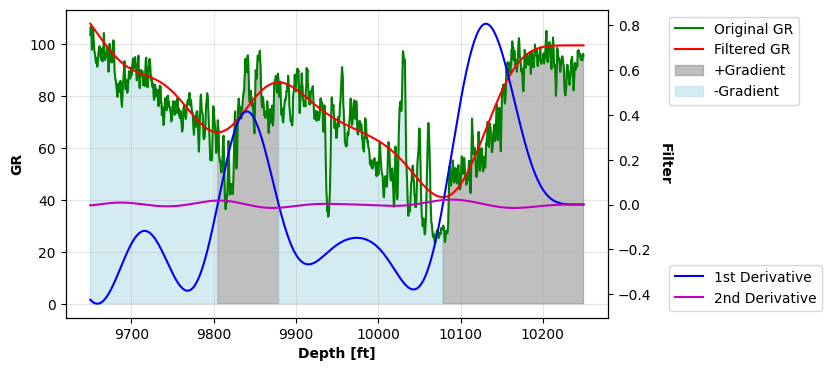

In [316]:
d = case1['GR']
grw = signal.filtfilt(*signal.butter(7, 5e-3), d)
dgrw = np.gradient(grw, d.index)
d2grw = np.gradient(dgrw, d.index)

fig, ax1 = plt.subplots(1,1, figsize=(7,4))

ax1.plot(d.index, d, color='g', label='Original GR')
ax1.plot(d.index, grw, color='r', label='Filtered GR')

ax2 = ax1.twinx()
ax2.plot(d.index, dgrw, color='b', label='1st Derivative')
ax2.plot(d.index, d2grw, color='m', label='2nd Derivative')

ax1.fill_between(d.index, 0, d, where=dgrw>0, color='grey', alpha=0.5, label='+Gradient')
ax1.fill_between(d.index, 0, d, where=dgrw<0, color='lightblue', alpha=0.5, label='-Gradient')

ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax1.set_ylabel('GR', weight='bold')
ax2.legend(bbox_to_anchor=(1.1, 0), loc='lower left')
ax2.set_ylabel('Filter', weight='bold', labelpad=15, rotation=270)
ax1.set_xlabel('Depth [ft]', weight='bold')
ax1.grid(True, which='both', alpha=0.33)
plt.show()

In [320]:
def fit_linear_trend_lines(data, num_segments):
    # Split the data into segments
    segment_length = len(data) // num_segments
    segments = [data[i:i+segment_length] for i in range(0, len(data), segment_length)]
    
    # Fit linear regression models to each segment
    models = []
    for segment in segments:
        X = np.arange(len(segment)).reshape(-1, 1)
        y = segment.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        models.append(model)
    
    # Predict values using the fitted models
    predicted_values = np.concatenate([model.predict(np.arange(len(segment)).reshape(-1, 1)) for model, segment in zip(models, segments)])
    
    return predicted_values, segments

predicted_trend, segments = fit_linear_trend_lines(np.array(d), 3)

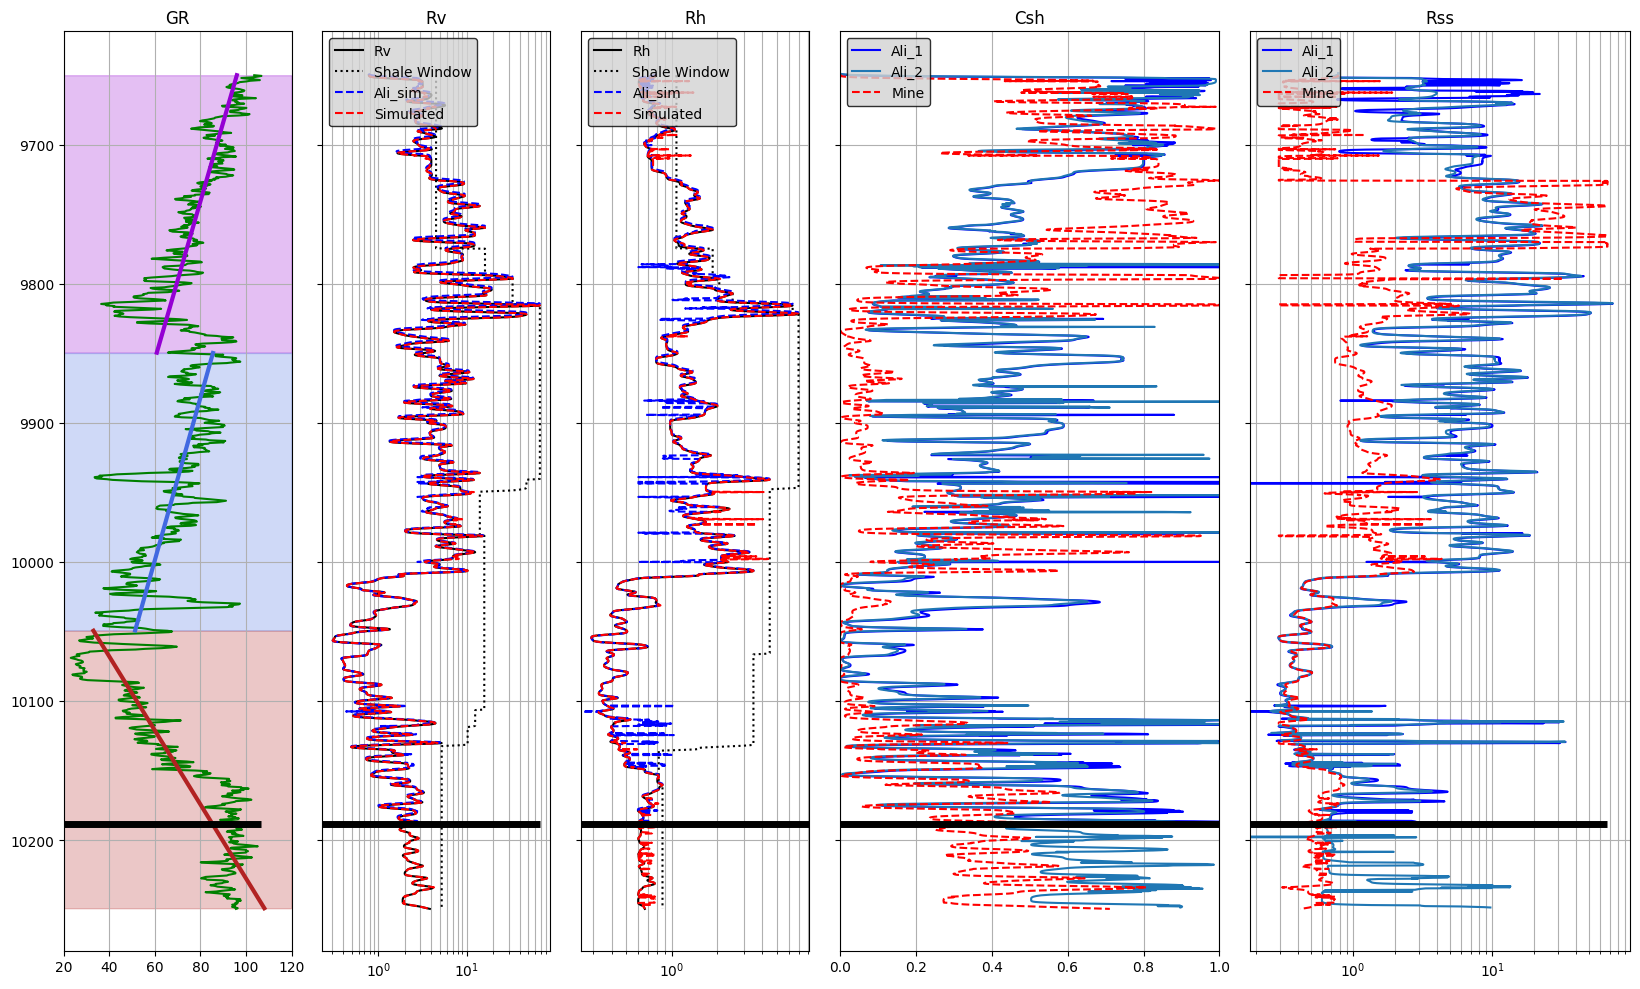

In [367]:
fig, axs = plt.subplots(1,5, figsize=(16.5,10), sharey=True, width_ratios=[0.6,0.6,0.6,1,1])
ax1, ax2, ax3, ax4, ax5 = axs

ax1.plot(case1['GR'], case1.index, c='g', label='GR')
colors = ['darkviolet','royalblue','firebrick']
for i, segment in enumerate(segments[:-1]):
    x = d.index[i*len(segment):(i+1)*len(segment)]
    y = predicted_trend[i*len(segment):(i+1)*len(segment)]
    ax1.fill_betweenx(x, 0, 120, label='Segment {}'.format(i+1), alpha=0.25, color=colors[i])
    ax1.plot(y, x, label='Trend {}'.format(i+1), lw=3, color=colors[i])
ax1.grid(True, which='both')
ax1.set(xlim=(20,120), title='GR')
ax1.hlines(10188.75, 0, case1['GR'].max(), color='k', lw=5)

ax2.plot(case1['Rv'], case1.index, c='k', label='Rv')
ax2.plot(case1['Rvsh_win'], case1.index, c='k', ls=':', lw=1.5, label='Shale Window')
ax2.plot(Rv_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
ax2.set(xscale='log', title='Rv')
ax2.grid(True, which='both')
ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax3.plot(case1['Rh'], case1.index, c='k', label='Rh')
ax3.plot(case1['Rhsh_win'], case1.index, c='k', ls=':', lw=1.5, label='Shale Window')
ax3.plot(Rh_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax3.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
ax3.set(xscale='log', title='Rh')
ax3.grid(True, which='both')
ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax3.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax4.plot(ali_Csh, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax4.plot(ali.iloc[:,14], ali.iloc[:,0], label='Ali_2')
ax4.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
ax4.set(title='Csh', xlim=(0,1))
ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax4.grid(True, which='both')
ax4.hlines(10188.75, 0, 1, color='k', lw=5)

ax5.plot(ali_Rss, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax5.plot(ali.iloc[:,15], ali.iloc[:,0], label='Ali_2')
ax5.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
ax5.set(xscale='log', title='Rss'); 
ax5.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax5.grid(True, which='both')
ax5.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

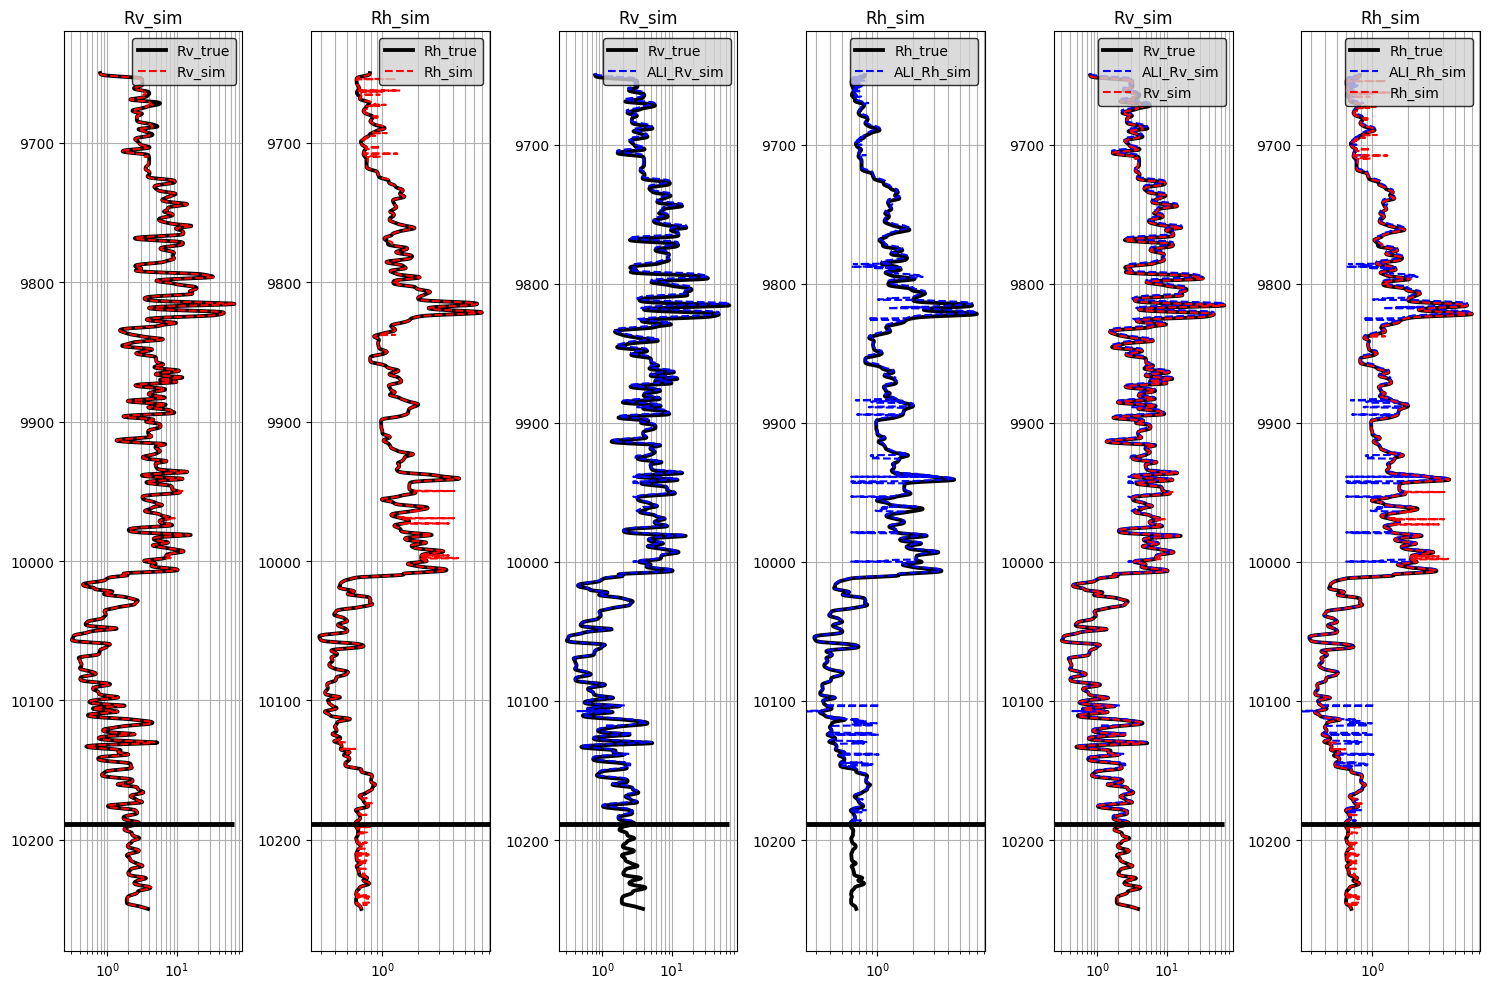

In [357]:
fig, axs = plt.subplots(1, 6, figsize=(15,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs

ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax3.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax4.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax5.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax6.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

for ax in axs:
    ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

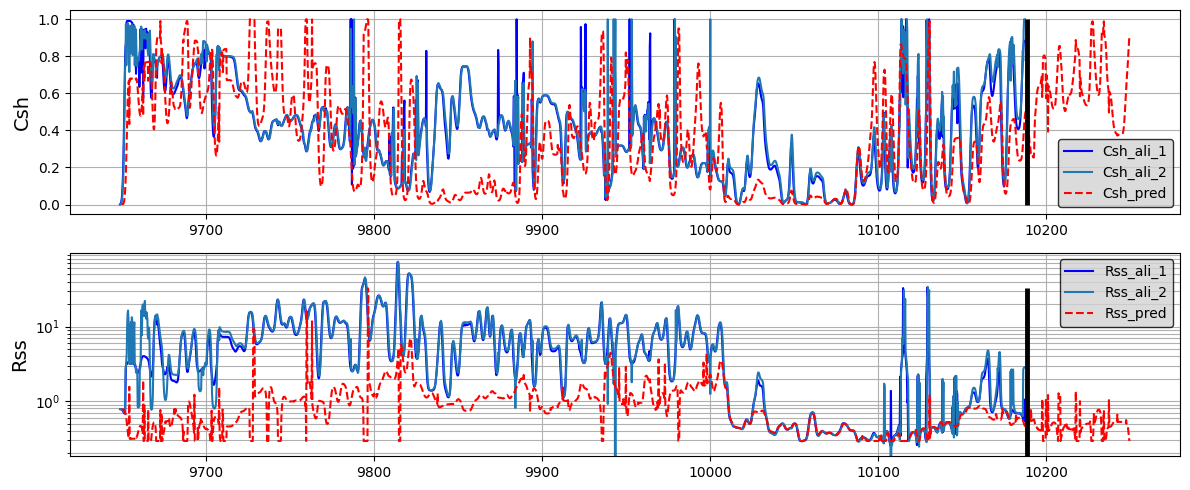

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(12,5))
ax1, ax2 = axs

gri = (case1['GR'] - case1['GR'].min())/(case1['GR'].max() - case1['GR'].min())

#ax1.plot(case1.index, gri, c='gray', label='GR_Index')
ax1.plot(ali.iloc[1:2156,0], ali.iloc[1:2156,14], c='b', label='Csh_ali_1')
ax1.plot(ali.iloc[1:2156,0], ali_Csh, c='tab:blue', label='Csh_ali_2')
ax1.plot(sol.index, sol['Csh_pred'], c='r', ls='--', label='Csh_pred')
ax1.set_ylabel('Csh', fontsize=14)
ax1.grid(True, which='both')
ax1.legend(facecolor='lightgrey', edgecolor='k')
ax1.vlines(10188.75, 0, 1, color='k', lw=3.5)

ax2.plot(ali.iloc[1:2156,0], ali.iloc[1:2156,15], c='b', label='Rss_ali_1')
ax2.plot(ali.iloc[1:2156,0], ali_Rss, c='tab:blue', label='Rss_ali_2')
ax2.plot(sol.index, sol['Rss_pred'], c='r', ls='--', label='Rss_pred')
ax2.set_ylabel('Rss', fontsize=14)
ax2.grid(True, which='both')
ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
ax2.set_yscale('log')
ax2.vlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)

plt.tight_layout()
plt.show()

In [23]:
df = lasio.read('well1.las').df()
df.columns

Index(['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALI', 'CORE_FLAG', 'COREPERM',
       'COREPOR', 'CORERHOB', 'CORERHOB_2SMT', 'CORERHOB_3SMT', 'CORERHOG',
       'CORESO', 'CORESW', 'DEPTH:2', 'DEPTH_ORIG', 'DPAA_TOH_72H_1D',
       'DPAP_72H_1D', 'DRHO', 'EHGR', 'FPRESS', 'FTEMP', 'GR', 'GR_CORE',
       'GR_SM', 'HAZI', 'HCGR', 'HSGR', 'HTHO', 'HURA', 'MSFT_72H_ALL_R',
       'MSFT_72H_ALL_X', 'PE', 'PHID_SS', 'POTA', 'RH72H_1D', 'RH72H_1D_FLT',
       'RHO8', 'RHOZ', 'RV72H_1D', 'RV72H_1D_FLT', 'SDEV', 'TENS', 'TNPH'],
      dtype='object')

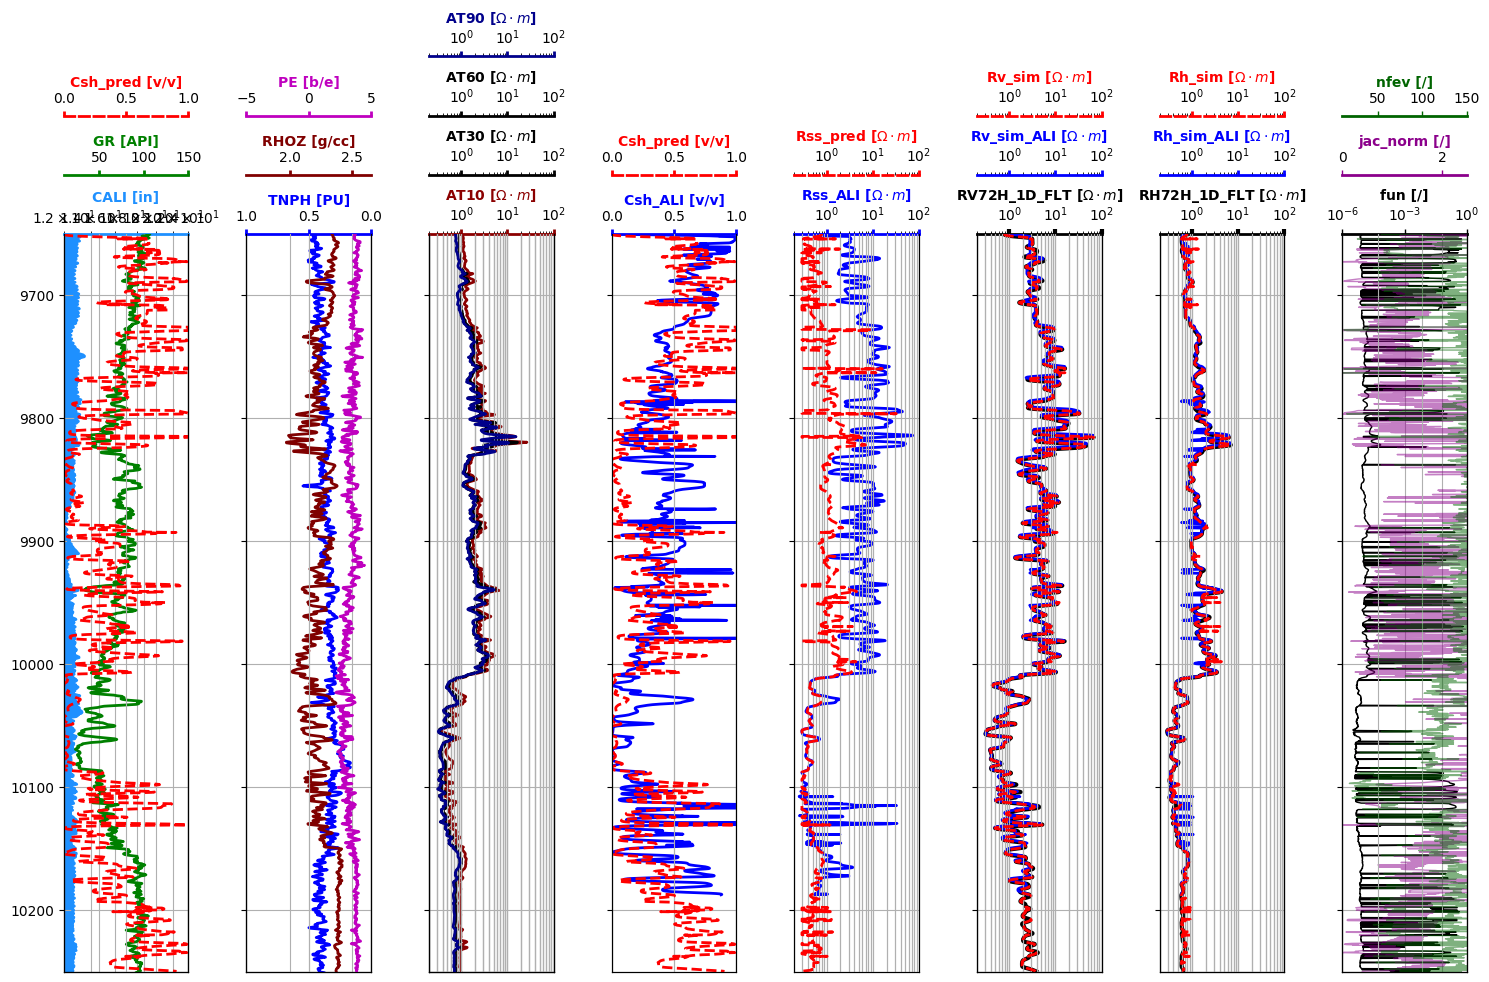

In [30]:
fig, axs = plt.subplots(1, 8, figsize=(15,10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
ari.plot_curve(ax1, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
ari.plot_curve(ax11, df, 'GR', 10, 150, 'g', units='API', pad=8)
ari.plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
ari.plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
ari.plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
ari.plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax31, df, 'AT30', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax32, df, 'AT60', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=16)
ari.plot_curve(ax33, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=24)

ax41 = ax4.twiny()
ari.plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
ari.plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)

ax51 = ax5.twiny()
ari.plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)

ax61, ax62 = ax6.twiny(), ax6.twiny()
ari.plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=3, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax71, ax72 = ax7.twiny(), ax7.twiny()
ari.plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=3, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax81, ax82 = ax8.twiny(), ax8.twiny()
ari.plot_curve(ax8, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
ari.plot_curve(ax81, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
ari.plot_curve(ax82, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)

ax1.set_ylim(10250, 9650)

plt.tight_layout()
plt.show()